# Problem Statement and Business Understanding

To maximize the profit for Insurance company, company need to really careful on calculating the premium price. If the premium is too high the customer will move to competitor, and if it is too low the risk of getting high loss ratio is increase as well

Using dynamic premium pricing, first we identify customer with high probability of claim and apply certain loading to the premium. Using this method, insurance also can avoid bad business by giving high premium rates for certain customer only.

The Data here :
https://drive.google.com/drive/folders/1ge_1PMFWLKUL3Q6CzH_OdPM-hZwK2IcK?usp=sharing

# Environment Preparation

## Import Library

In [9]:
# !pip install xgb
!pip install xgboost
!pip install category_encoders
!pip install python-dateutil
!pip install seaborn
!pip install lightgbm
!pip install seaborn matplotlib
!pip install shap




In [10]:
import pandas as pd #library to wrangling the data
from dateutil import parser #library to manipulate date
import numpy as np #library to manipulating data
import seaborn as sns #library for visualization
import matplotlib.pyplot as plt #library for visualization
from sklearn.preprocessing import StandardScaler #Scaling variable
from sklearn.model_selection import train_test_split #split training and testing data
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

# Feature Engineering
import category_encoders as ce

# model creation
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import RandomForestClassifier #Random Forest
import lightgbm as lgb

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import shap

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format #formating of the number
import warnings
warnings.filterwarnings('ignore')

c:\Users\arima\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load all the data

In [11]:
df_customer = pd.read_csv('data/customer.csv')
df_historical_claims = pd.read_csv('data/historical_claims.csv')
df_open_claims = pd.read_csv('data/open_claims.csv')
df_policies_new = pd.read_csv('data/policies_new.csv')
df_vehicle_new = pd.read_csv('data/vehicle_new.csv')

# Create data pipeline

Create a datamart by combining all table, using the join key



In [12]:
df_claims_per_policy = pd.pivot_table(df_historical_claims,
                                      index='POLICY_IDENTIFIER',
                                      aggfunc={'TOTAL_CLAIM_PAID_AMOUNT':'sum',
                                               'CLAIM_PAID_AMOUNT_INSURER':'count'}).reset_index()
df_claims_per_policy.rename(columns={'TOTAL_CLAIM_PAID_AMOUNT':'CLAIM_AMOUNT','CLAIM_PAID_AMOUNT_INSURER':'CLAIM_COUNT'},inplace=True)

In [13]:
temp1 = pd.merge(df_policies_new,df_claims_per_policy,how='left',on='POLICY_IDENTIFIER',suffixes=('_policy','_claim'))
temp2 = pd.merge(temp1,df_vehicle_new,how='left',on='VEHICLE_IDENTIFIER')
temp3 = pd.merge(temp2,df_customer,how='left',on='CUSTOMER_IDENTIFIER')

In [14]:
datamart = temp3.copy()
datamart.to_csv('datamart.csv',index=False)

In [15]:
datamart = pd.read_csv('datamart.csv')

# Dynamic Insurance Pricing

## Data Cleansing

In [16]:
datamart.dtypes

POLICY_WRITTEN_BRANCH     object
POLICY_IDENTIFIER         object
PREVIOUS_INSURER_NAME     object
POLICY_START_DATE         object
POLICY_END_DATE           object
CANCELLATION_DATE         object
SUM_INSURED              float64
GWP                        int64
COMPULSORY_DEDUCTABLE      int64
PRODUCT                   object
PRODUCT_CODE              object
VEHICLE_IDENTIFIER        object
CLAIM_COUNT              float64
CLAIM_AMOUNT             float64
YEAR_OF_MANUFACTURE        int64
MAKE_OF_VEHICLE           object
VEHICLE_TYPE              object
SEATING_CAPACITY           int64
ENGINE_SIZE_CC             int64
VEHICLE_GROSS_WEIGHT       int64
CUSTOMER_IDENTIFIER       object
GENDER                    object
DRIVING_EXPERIENCE        object
dtype: object

In [17]:
# Check Missing Value
datamart.isna().sum()

POLICY_WRITTEN_BRANCH          0
POLICY_IDENTIFIER              0
PREVIOUS_INSURER_NAME          0
POLICY_START_DATE              0
POLICY_END_DATE                0
CANCELLATION_DATE        1780000
SUM_INSURED                    0
GWP                            0
COMPULSORY_DEDUCTABLE          0
PRODUCT                        0
PRODUCT_CODE                   0
VEHICLE_IDENTIFIER             0
CLAIM_COUNT              2837875
CLAIM_AMOUNT             2837875
YEAR_OF_MANUFACTURE            0
MAKE_OF_VEHICLE                0
VEHICLE_TYPE                   0
SEATING_CAPACITY               0
ENGINE_SIZE_CC                 0
VEHICLE_GROSS_WEIGHT           0
CUSTOMER_IDENTIFIER            0
GENDER                         0
DRIVING_EXPERIENCE             0
dtype: int64

In [18]:
datamart['CANCELLATION_DATE'] = datamart['CANCELLATION_DATE'].fillna('NA')
datamart['CLAIM_AMOUNT'] = datamart['CLAIM_AMOUNT'].fillna(0)
datamart['CLAIM_COUNT'] = datamart['CLAIM_COUNT'].fillna(0)

In [19]:
datamart.isna().sum()

POLICY_WRITTEN_BRANCH    0
POLICY_IDENTIFIER        0
PREVIOUS_INSURER_NAME    0
POLICY_START_DATE        0
POLICY_END_DATE          0
CANCELLATION_DATE        0
SUM_INSURED              0
GWP                      0
COMPULSORY_DEDUCTABLE    0
PRODUCT                  0
PRODUCT_CODE             0
VEHICLE_IDENTIFIER       0
CLAIM_COUNT              0
CLAIM_AMOUNT             0
YEAR_OF_MANUFACTURE      0
MAKE_OF_VEHICLE          0
VEHICLE_TYPE             0
SEATING_CAPACITY         0
ENGINE_SIZE_CC           0
VEHICLE_GROSS_WEIGHT     0
CUSTOMER_IDENTIFIER      0
GENDER                   0
DRIVING_EXPERIENCE       0
dtype: int64

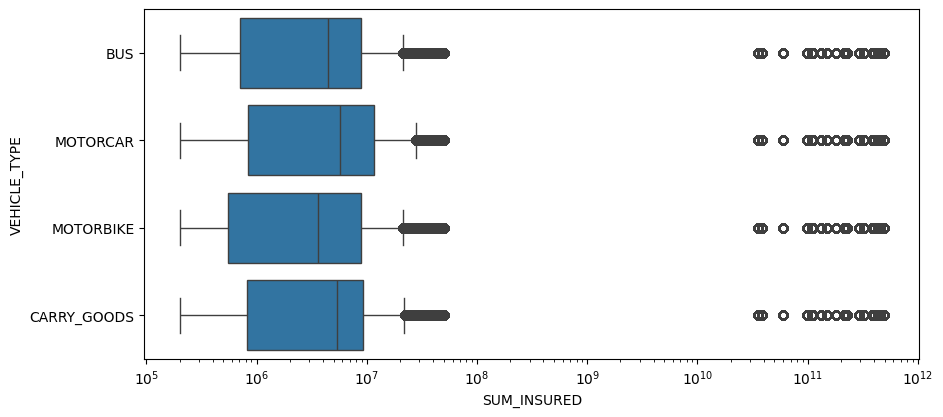

In [20]:
# Check Outlier in Sum Insured
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
sns.boxplot(x=datamart.SUM_INSURED,y = datamart.VEHICLE_TYPE)
ax.set_xscale('log')
plt.show()

In [21]:
# Remove Outlier in Sum Insured, replace it with max value

temp = datamart[['POLICY_IDENTIFIER','SUM_INSURED','VEHICLE_TYPE']]
result = []

def calculate_upper_wisker(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  Range = Q3 - Q1
  U = Q3 + 1.5 * Range
  return U

for vehicle in temp.VEHICLE_TYPE.unique():
  data = temp[temp.VEHICLE_TYPE==vehicle]
  Upper = calculate_upper_wisker(data.SUM_INSURED)
  # data['OUTLIER_FLAG'] = np.where(data.SUM_INSURED > Upper,True,False)
  data['SUM_INSURED'] = np.where(data.SUM_INSURED > Upper,Upper,data.SUM_INSURED)

  result.append(data)

temp = pd.concat(result)

In [22]:
temp2 = datamart.copy()
temp2['SUM_INSURED'] = temp['SUM_INSURED']

In [23]:
datamart_clean = temp2.copy()

In [24]:
datamart_clean.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05,2016-05-06,2013-01-22,2015-07-21,2016-01-06
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NA,NA,NA,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


## Feature Engineering

In [25]:
datamart_clean.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05,2016-05-06,2013-01-22,2015-07-21,2016-01-06
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NA,NA,NA,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [26]:
temp = datamart_clean.copy()
temp['TARGET'] = np.where(temp.CLAIM_COUNT>=1,1,0)
temp['CUSTOMER_TYPE'] = np.where(temp.PREVIOUS_INSURER_NAME == 'MAIN_INSURANCE','EXISTING','NEW')
temp.POLICY_START_DATE = pd.to_datetime(temp.POLICY_START_DATE)
temp['PURCHASE_MONTH'] = pd.DatetimeIndex(temp.POLICY_START_DATE).month
temp['VEHICLE_AGE'] = pd.DatetimeIndex(temp.POLICY_START_DATE).year - temp.YEAR_OF_MANUFACTURE
temp['BUSINESS_TYPE'] = np.where(temp.PRODUCT.str.contains('COMMERCIAL'),'COMMERCIAL',np.where(temp.PRODUCT.str.contains('PRIVATE'),'PRIVATE','OTHER'))
temp.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05 00:00:00,2016-05-06 00:00:00,2013-01-22 00:00:00,2015-07-21 00:00:00,2016-01-06 00:00:00
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NA,NA,NA,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [27]:
# Extract previous policy information for each customer
temp2 = temp[temp.CANCELLATION_DATE=='NA'][['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','POLICY_START_DATE','POLICY_END_DATE','CLAIM_COUNT','CLAIM_AMOUNT']].sort_values(by = ['CUSTOMER_IDENTIFIER','POLICY_START_DATE'],ascending=True)
temp2.head()

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,CLAIM_COUNT,CLAIM_AMOUNT
3399624,CUSTOMER_1,VEHICLE_1057258,2016-10-30,2017-10-29,1.00,"20,318.00"
3289503,CUSTOMER_10,VEHICLE_946884,2012-10-13,2013-10-12,1.00,"4,708.00"
803573,CUSTOMER_100,VEHICLE_1394226,2015-10-09,2016-10-07,0.00,0.00
1328193,CUSTOMER_100,VEHICLE_1394226,2016-10-03,2017-10-02,0.00,0.00
3239141,CUSTOMER_1000,VEHICLE_1415386,2012-10-24,2013-10-23,0.00,0.00


In [28]:
pd.pivot_table(temp2,index='CUSTOMER_IDENTIFIER',aggfunc={'CLAIM_COUNT':'count'}).reset_index().sort_values(by='CLAIM_COUNT',ascending=False).head(10)

,CUSTOMER_IDENTIFIER,CLAIM_COUNT
393039,CUSTOMER_582083,24
400165,CUSTOMER_591368,23
483552,CUSTOMER_701178,23
334630,CUSTOMER_505112,22
617151,CUSTOMER_876465,20
228441,CUSTOMER_365418,20
533509,CUSTOMER_766936,19
352478,CUSTOMER_528745,19
320452,CUSTOMER_486508,19
559322,CUSTOMER_800679,19


In [29]:
# Example of repeat customer
temp2[temp2.CUSTOMER_IDENTIFIER == 'CUSTOMER_705545']

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,CLAIM_COUNT,CLAIM_AMOUNT
2380022,CUSTOMER_705545,VEHICLE_214261,2012-05-06,2013-05-05,1.00,"195,580.00"
1956261,CUSTOMER_705545,VEHICLE_214261,2012-10-28,2013-10-27,1.00,"3,538.00"
1994419,CUSTOMER_705545,VEHICLE_214261,2013-11-07,2014-11-06,2.00,"7,425.00"
1605120,CUSTOMER_705545,VEHICLE_214261,2014-08-15,2015-08-14,2.00,"35,063.00"
392531,CUSTOMER_705545,VEHICLE_214261,2017-07-17,2018-07-16,1.00,"27,704.00"
2561743,CUSTOMER_705545,VEHICLE_214261,2018-07-19,2019-07-18,1.00,"15,296.00"


In [30]:
# Feature Engineering on repeat customer
temp3 = temp2.copy()
temp3['PREVIOUS_START_DATE'] = pd.to_datetime(temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['POLICY_START_DATE'].shift(1))
temp3['PREVIOUS_END_DATE'] = pd.to_datetime(temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['POLICY_END_DATE'].shift(1))
temp3['PREVIOUS_CLAIM_COUNT'] = temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['CLAIM_COUNT'].shift(1)
temp3['PREVIOUS_CLAIM_AMOUNT'] = temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['CLAIM_AMOUNT'].shift(1)

In [31]:
temp3.head()

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,CLAIM_COUNT,CLAIM_AMOUNT,PREVIOUS_START_DATE,PREVIOUS_END_DATE,PREVIOUS_CLAIM_COUNT,PREVIOUS_CLAIM_AMOUNT
3399624,CUSTOMER_1,VEHICLE_1057258,2016-10-30,2017-10-29,1.00,"20,318.00",NaT,NaT,NaN,NaN
3289503,CUSTOMER_10,VEHICLE_946884,2012-10-13,2013-10-12,1.00,"4,708.00",NaT,NaT,NaN,NaN
803573,CUSTOMER_100,VEHICLE_1394226,2015-10-09,2016-10-07,0.00,0.00,NaT,NaT,NaN,NaN
1328193,CUSTOMER_100,VEHICLE_1394226,2016-10-03,2017-10-02,0.00,0.00,2015-10-09,2016-10-07,0.00,0.00
3239141,CUSTOMER_1000,VEHICLE_1415386,2012-10-24,2013-10-23,0.00,0.00,NaT,NaT,NaN,NaN


In [32]:
temp3.dtypes

CUSTOMER_IDENTIFIER              object
VEHICLE_IDENTIFIER               object
POLICY_START_DATE        datetime64[ns]
POLICY_END_DATE                  object
CLAIM_COUNT                     float64
CLAIM_AMOUNT                    float64
PREVIOUS_START_DATE      datetime64[ns]
PREVIOUS_END_DATE        datetime64[ns]
PREVIOUS_CLAIM_COUNT            float64
PREVIOUS_CLAIM_AMOUNT           float64
dtype: object

In [33]:
temp3[['POLICY_START_DATE', 'PREVIOUS_END_DATE']].isna().sum()

POLICY_START_DATE          0
PREVIOUS_END_DATE    1074197
dtype: int64

In [34]:
temp3['SAME_VEHICLE_INSURED'] = np.where(temp3.PREVIOUS_START_DATE.isna(),False,True)
temp3['PREVIOUS_POLICIES_CLAIM'] = np.where(temp3.PREVIOUS_CLAIM_COUNT.isna(),False,True)
# temp3['PERIOD_TO_NEXT_POLICIES'] = np.where(temp3.PREVIOUS_END_DATE.isna(),0,(temp3.POLICY_START_DATE - temp3.PREVIOUS_END_DATE))

temp3['PERIOD_TO_NEXT_POLICIES'] = np.where(
    temp3.PREVIOUS_END_DATE.isna(),
    np.timedelta64(0, 'D'),
    temp3.POLICY_START_DATE - temp3.PREVIOUS_END_DATE
)


In [35]:
temp4 = temp3[~temp3.PREVIOUS_START_DATE.isnull()]
temp4.drop(['PREVIOUS_START_DATE','PREVIOUS_END_DATE','CLAIM_AMOUNT','CLAIM_COUNT'],axis=1,inplace=True)

In [36]:
temp4.head()

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,PREVIOUS_CLAIM_COUNT,PREVIOUS_CLAIM_AMOUNT,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,PERIOD_TO_NEXT_POLICIES
1328193,CUSTOMER_100,VEHICLE_1394226,2016-10-03,2017-10-02,0.00,0.00,True,True,-4 days
962714,CUSTOMER_1000,VEHICLE_46254,2013-10-05,2014-10-04,0.00,0.00,True,True,-83 days
1410075,CUSTOMER_1000,VEHICLE_46254,2017-05-01,2018-04-30,0.00,0.00,True,True,940 days
2468556,CUSTOMER_1000000,VEHICLE_205603,2016-03-25,2017-03-24,0.00,0.00,True,True,267 days
2443541,CUSTOMER_1000003,VEHICLE_57310,2016-11-16,2017-11-15,1.00,"141,579.00",True,True,691 days


In [37]:
temp5 = pd.merge(temp,temp4,how='left',on = ['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','POLICY_START_DATE','POLICY_END_DATE'])
temp5.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05 00:00:00,2016-05-06 00:00:00,2013-01-22 00:00:00,2015-07-21 00:00:00,2016-01-06 00:00:00
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NA,NA,NA,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [38]:
temp6 = temp5[temp5.CANCELLATION_DATE!='NA']

In [39]:
temp6['EXPERIENCE_CLAIM'] = np.where(temp6.PREVIOUS_POLICIES_CLAIM.isna(),'NEVER CLAIM','HAVE CLAIM')
temp6['EXPERIENCE_CLAIM_SEVERITY'] = np.where(temp6.PREVIOUS_CLAIM_AMOUNT.isna(),'NEVER CLAIM',
                                              np.where(temp6.PREVIOUS_CLAIM_AMOUNT<5000,'MINOR CLAIM',
                                                       np.where(temp6.PREVIOUS_CLAIM_AMOUNT<20000,'SMALL CLAIM',
                                                                np.where(temp6.PREVIOUS_CLAIM_AMOUNT<50000,'MEDIUM CLAIM','MAJOR CLAIM'
                                                                ))))
temp6['SAME_VEHICLE_INSURED'] = np.where(temp6.CUSTOMER_TYPE=='NEW','NEW CUSTOMER',
                                         np.where(temp6.SAME_VEHICLE_INSURED==True,'SAME VEHICLE','DIFFERENT VEHICLE'))

temp6['RENEWAL_PERIOD'] = np.where(temp6.PERIOD_TO_NEXT_POLICIES.isnull(),'NEW POLICY',
                                 np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<0,'BEFORE POLICY END',
                                          np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<30,'ONE MONTH BEFORE',
                                                   np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<180,'SIX MONTH BEFORE',
                                                            np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<360,'ONE YEAR BEFORE','MORE THAN ONE YEAR')))))

temp6['PREVIOUS_POLICIES_CLAIM'] = np.where(temp6.PREVIOUS_POLICIES_CLAIM.isna(),'NEW POLICY',
                                            np.where(temp6.PREVIOUS_POLICIES_CLAIM,'YES','NO'))

In [40]:
temp6.head().T

,0,4,5,11,12
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2950161,POLICY_2904539,POLICY_193545,POLICY_3102154
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,MAIN_INSURANCE,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05 00:00:00,2016-01-06 00:00:00,2015-07-03 00:00:00,2013-06-09 00:00:00,2019-09-14 00:00:00
POLICY_END_DATE,2015-05-04,2017-01-04,2016-07-01,2014-06-08,2020-09-12
CANCELLATION_DATE,2015-05-04,2017-01-02,2016-03-19,2014-03-13,2020-09-12
SUM_INSURED,"7,800,000.00","4,480,000.00","2,900,000.00","380,000.00","870,000.00"
GWP,69911,27824,52763,1545,7517
COMPULSORY_DEDUCTABLE,2000,1000,1000,2000,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,LONG TERM TWO WHEELER PACKAGE,COMMERCIAL MOTOR PASSENGER CARRYING,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER


In [41]:
pd.pivot_table(temp6,index='PREVIOUS_POLICIES_CLAIM',aggfunc={'GWP':'count'})

,GWP
PREVIOUS_POLICIES_CLAIM,
NEW POLICY,1649673
YES,327


In [42]:
temp6.drop(['PREVIOUS_INSURER_NAME','POLICY_START_DATE','POLICY_END_DATE','CANCELLATION_DATE',
            'PRODUCT','CLAIM_COUNT','CLAIM_AMOUNT','CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','PREVIOUS_CLAIM_COUNT','PREVIOUS_CLAIM_AMOUNT','PERIOD_TO_NEXT_POLICIES'],axis=1,inplace=True)
df_model = temp6.copy()

# temp6['EXPERIENCE_CLAIM'] = np.where(temp6.PREVIOUS_POLICIES_CLAIM.isna(),'NEVER CLAIM','HAVE CLAIM')

In [43]:
df_model.head()

,POLICY_WRITTEN_BRANCH,POLICY_IDENTIFIER,SUM_INSURED,GWP,COMPULSORY_DEDUCTABLE,PRODUCT_CODE,YEAR_OF_MANUFACTURE,MAKE_OF_VEHICLE,VEHICLE_TYPE,SEATING_CAPACITY,...,TARGET,CUSTOMER_TYPE,PURCHASE_MONTH,VEHICLE_AGE,BUSINESS_TYPE,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,EXPERIENCE_CLAIM,EXPERIENCE_CLAIM_SEVERITY,RENEWAL_PERIOD
0,BRANCH_104,POLICY_2981310,"7,800,000.00",69911,2000,product_ 3,2003,TOYOTA,BUS,31,...,0,EXISTING,5,11,COMMERCIAL,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
4,BRANCH_104,POLICY_2950161,"4,480,000.00",27824,1000,product_ 7,2004,TOYOTA,MOTORBIKE,2,...,0,EXISTING,1,12,OTHER,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
5,BRANCH_104,POLICY_2904539,"2,900,000.00",52763,1000,product_ 5,2012,Maserati,MOTORCAR,3,...,0,EXISTING,7,3,COMMERCIAL,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
11,BRANCH_104,POLICY_193545,"380,000.00",1545,2000,product_ 1,2003,Volvo,MOTORCAR,2,...,0,EXISTING,6,10,PRIVATE,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
12,BRANCH_104,POLICY_3102154,"870,000.00",7517,1000,product_ 1,2002,TVS MOTORS,MOTORCAR,3,...,0,EXISTING,9,17,PRIVATE,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY


## Encode Categorical Variable

In [44]:
df_model.dtypes

POLICY_WRITTEN_BRANCH         object
POLICY_IDENTIFIER             object
SUM_INSURED                  float64
GWP                            int64
COMPULSORY_DEDUCTABLE          int64
PRODUCT_CODE                  object
YEAR_OF_MANUFACTURE            int64
MAKE_OF_VEHICLE               object
VEHICLE_TYPE                  object
SEATING_CAPACITY               int64
ENGINE_SIZE_CC                 int64
VEHICLE_GROSS_WEIGHT           int64
GENDER                        object
DRIVING_EXPERIENCE            object
TARGET                         int32
CUSTOMER_TYPE                 object
PURCHASE_MONTH                 int32
VEHICLE_AGE                    int64
BUSINESS_TYPE                 object
SAME_VEHICLE_INSURED          object
PREVIOUS_POLICIES_CLAIM       object
EXPERIENCE_CLAIM              object
EXPERIENCE_CLAIM_SEVERITY     object
RENEWAL_PERIOD                object
dtype: object

In [45]:
df_numerical = df_model.select_dtypes(exclude='object')
df_categorical = df_model.select_dtypes(include='object')
df_numerical.drop('TARGET',axis=1,inplace=True)
target = df_model.TARGET
id = df_model.POLICY_IDENTIFIER

In [46]:
df_categorical.describe()

,POLICY_WRITTEN_BRANCH,POLICY_IDENTIFIER,PRODUCT_CODE,MAKE_OF_VEHICLE,VEHICLE_TYPE,GENDER,DRIVING_EXPERIENCE,CUSTOMER_TYPE,BUSINESS_TYPE,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,EXPERIENCE_CLAIM,EXPERIENCE_CLAIM_SEVERITY,RENEWAL_PERIOD
count,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000,1650000
unique,123,1650000,7,46,4,2,6,2,3,3,2,2,4,6
top,BRANCH_34,POLICY_2981310,product_ 1,TVS MOTORS,MOTORCAR,M,THREE_TO_FIVE_YEARS,EXISTING,PRIVATE,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
freq,67369,1,548689,50942,686213,1320538,1221701,1409820,738833,1409530,1649673,1649673,1649673,1649673


In [47]:
print(df_categorical.columns)


Index(['POLICY_WRITTEN_BRANCH', 'POLICY_IDENTIFIER', 'PRODUCT_CODE',
       'MAKE_OF_VEHICLE', 'VEHICLE_TYPE', 'GENDER', 'DRIVING_EXPERIENCE',
       'CUSTOMER_TYPE', 'BUSINESS_TYPE', 'SAME_VEHICLE_INSURED',
       'PREVIOUS_POLICIES_CLAIM', 'EXPERIENCE_CLAIM',
       'EXPERIENCE_CLAIM_SEVERITY', 'RENEWAL_PERIOD'],
      dtype='object')


Encode variable split into 2,
1. One Hot Encode
2. Target Encode
3. Binary Encode

In [48]:
# Encode category
onehot_encode = ['VEHICLE_TYPE','GENDER','CUSTOMER_TYPE','BUSINESS_TYPE','SAME_VEHICLE_INSURED','PREVIOUS_POLICIES_CLAIM','EXPERIENCE_CLAIM']
target_encode = ['POLICY_WRITTEN_BRANCH','MAKE_OF_VEHICLE']
binary_encode = ['PRODUCT_CODE','DRIVING_EXPERIENCE','EXPERIENCE_CLAIM_SEVERITY','RENEWAL_PERIOD']

temp_onehot = df_categorical[onehot_encode]
temp_target = df_categorical[target_encode]
temp_binary = df_categorical[binary_encode]

In [49]:
# One hot encode
temp_onehot2 = pd.get_dummies(temp_onehot,drop_first=True)
temp_onehot2.head()

,VEHICLE_TYPE_CARRY_GOODS,VEHICLE_TYPE_MOTORBIKE,VEHICLE_TYPE_MOTORCAR,GENDER_M,CUSTOMER_TYPE_NEW,BUSINESS_TYPE_OTHER,BUSINESS_TYPE_PRIVATE,SAME_VEHICLE_INSURED_NEW CUSTOMER,SAME_VEHICLE_INSURED_SAME VEHICLE,PREVIOUS_POLICIES_CLAIM_YES,EXPERIENCE_CLAIM_NEVER CLAIM
0,False,False,False,True,False,False,False,False,False,False,True
4,False,True,False,True,False,True,False,False,False,False,True
5,False,False,True,True,False,False,False,False,False,False,True
11,False,False,True,True,False,False,True,False,False,False,True
12,False,False,True,False,False,False,True,False,False,False,True


In [50]:
# target encode

temp_target1 = pd.pivot_table(datamart,index='POLICY_WRITTEN_BRANCH',aggfunc={'GWP':'sum','SUM_INSURED':'count','CLAIM_AMOUNT':'sum','CLAIM_COUNT':'sum'}).reset_index()
temp_target1['LOSS_RATIO_BRANCH'] = temp_target1['CLAIM_AMOUNT']/temp_target1['GWP']
temp_target1['INCIDENT_RATE_BRANCH'] = temp_target1['CLAIM_COUNT']/temp_target1['SUM_INSURED']
temp_target_branch = temp_target1[['POLICY_WRITTEN_BRANCH','LOSS_RATIO_BRANCH','INCIDENT_RATE_BRANCH']]

temp_target1 = pd.pivot_table(datamart,index='MAKE_OF_VEHICLE',aggfunc={'GWP':'sum','SUM_INSURED':'count','CLAIM_AMOUNT':'sum','CLAIM_COUNT':'sum'}).reset_index()
temp_target1['LOSS_RATIO_VEHICLE'] = temp_target1['CLAIM_AMOUNT']/temp_target1['GWP']
temp_target1['INCIDENT_RATE_VEHICLE'] = temp_target1['CLAIM_COUNT']/temp_target1['SUM_INSURED']
temp_target_vehicle = temp_target1[['MAKE_OF_VEHICLE','LOSS_RATIO_VEHICLE','INCIDENT_RATE_VEHICLE']]


In [51]:
temp_target1 = pd.merge(df_categorical[['MAKE_OF_VEHICLE','POLICY_WRITTEN_BRANCH']],temp_target_branch,how='left',on='POLICY_WRITTEN_BRANCH')
temp_target2 = pd.merge(temp_target1,temp_target_vehicle,how='left',on='MAKE_OF_VEHICLE')

In [52]:
# binary encode

encoder= ce.BinaryEncoder(cols=binary_encode,return_df=True)
temp_binary2=encoder.fit_transform(temp_binary)

In [53]:
temp1 = pd.concat([target,id,df_numerical,temp_onehot2,temp_binary2,df_categorical[['MAKE_OF_VEHICLE','POLICY_WRITTEN_BRANCH']]],axis=1)
temp2 = pd.merge(temp1,temp_target_branch,how='left',on='POLICY_WRITTEN_BRANCH')
temp3 = pd.merge(temp2,temp_target_vehicle,how='left',on='MAKE_OF_VEHICLE')
temp3.drop(['POLICY_WRITTEN_BRANCH','MAKE_OF_VEHICLE'],axis=1,inplace=True)
df_encode = temp3.copy()

In [54]:
df_encode.to_csv('encode.csv',index=False)

In [55]:
df_encode.head()

,TARGET,POLICY_IDENTIFIER,SUM_INSURED,GWP,COMPULSORY_DEDUCTABLE,YEAR_OF_MANUFACTURE,SEATING_CAPACITY,ENGINE_SIZE_CC,VEHICLE_GROSS_WEIGHT,PURCHASE_MONTH,...,EXPERIENCE_CLAIM_SEVERITY_0,EXPERIENCE_CLAIM_SEVERITY_1,EXPERIENCE_CLAIM_SEVERITY_2,RENEWAL_PERIOD_0,RENEWAL_PERIOD_1,RENEWAL_PERIOD_2,LOSS_RATIO_BRANCH,INCIDENT_RATE_BRANCH,LOSS_RATIO_VEHICLE,INCIDENT_RATE_VEHICLE
0,0,POLICY_2981310,"7,800,000.00",69911,2000,2003,31,1320,2495,5,...,0,0,1,0,0,1,0.19,0.19,0.16,0.19
1,0,POLICY_2950161,"4,480,000.00",27824,1000,2004,2,760,3700,1,...,0,0,1,0,0,1,0.19,0.19,0.16,0.19
2,0,POLICY_2904539,"2,900,000.00",52763,1000,2012,3,660,590,7,...,0,0,1,0,0,1,0.19,0.19,0.19,0.19
3,0,POLICY_193545,"380,000.00",1545,2000,2003,2,1270,980,6,...,0,0,1,0,0,1,0.19,0.19,0.19,0.19
4,0,POLICY_3102154,"870,000.00",7517,1000,2002,3,900,38500,9,...,0,0,1,0,0,1,0.19,0.19,0.16,0.19


In [56]:
df_encode.dtypes

TARGET                                 int32
POLICY_IDENTIFIER                     object
SUM_INSURED                          float64
GWP                                    int64
COMPULSORY_DEDUCTABLE                  int64
YEAR_OF_MANUFACTURE                    int64
SEATING_CAPACITY                       int64
ENGINE_SIZE_CC                         int64
VEHICLE_GROSS_WEIGHT                   int64
PURCHASE_MONTH                         int32
VEHICLE_AGE                            int64
VEHICLE_TYPE_CARRY_GOODS                bool
VEHICLE_TYPE_MOTORBIKE                  bool
VEHICLE_TYPE_MOTORCAR                   bool
GENDER_M                                bool
CUSTOMER_TYPE_NEW                       bool
BUSINESS_TYPE_OTHER                     bool
BUSINESS_TYPE_PRIVATE                   bool
SAME_VEHICLE_INSURED_NEW CUSTOMER       bool
SAME_VEHICLE_INSURED_SAME VEHICLE       bool
PREVIOUS_POLICIES_CLAIM_YES             bool
EXPERIENCE_CLAIM_NEVER CLAIM            bool
PRODUCT_CO

## Train Test Split

In [57]:
X = df_encode.iloc[:,1:].values
y = df_encode.iloc[:,0].values

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,train_size=0.5)

In [59]:
X_train_id = X_train[:,0]
X_test_id = X_test[:,0]
X_val_id = X_val[:,0]

X_train = X_train[:,1:]
X_test = X_test[:,1:]
X_val = X_val[:,1:]

# Model Training Using CatBoost

## Model Training

In [60]:
!pip install catboost

from catboost import CatBoostClassifier

# Initialize CatBoost model
model_cat = CatBoostClassifier(
    iterations=500,  # Total trees
    learning_rate=0.1,  # Learning rate
    depth=6,  # Depth of the trees
    eval_metric='F1',  # Metric for evaluation
    random_seed=42,
    verbose=0  # Suppress output
)

# Fit the model
model_cat.fit(X_train, y_train)


## Model Evaluation

In [61]:
def model_evaluation(classfier,X,y):
    y_proba = classfier.predict_proba(X)[:, 1]
    y_pred = np.where(y_proba<0.55,0,1)

    cm = confusion_matrix(y,y_pred)
    print('Confussin Matrix :')
    print(cm)
    print('\nModel Metrics')
    print('Accuracy   :{}'.format(accuracy_score(y,y_pred)))
    print('Precision  :{}'.format(precision_score(y,y_pred)))
    print('Recall     :{}'.format(recall_score(y,y_pred)))
    print('F1         :{}'.format(f1_score(y,y_pred)))
    print('ROC AUC    :{}'.format(roc_auc_score(y,y_pred)))

In [62]:
print('Train')
model_evaluation(model_cat, X_train, y_train)
print('Test')
model_evaluation(model_cat, X_test, y_test)
print('Val')
model_evaluation(model_cat, X_val, y_val)


Train
Confussin Matrix :
[[1092117       4]
 [ 197781   30098]]

Model Metrics
Accuracy   :0.8501628787878788
Precision  :0.9998671184638894
Recall     :0.13207886641594882
F1         :0.23333501304359625
ROC AUC    :0.5660376019090616
Test
Confussin Matrix :
[[136600      1]
 [ 24645   3754]]

Model Metrics
Accuracy   :0.8506303030303031
Precision  :0.9997336884154461
Recall     :0.13218775308989753
F1         :0.2335012751135162
ROC AUC    :0.5660902162496362
Val
Confussin Matrix :
[[136474      2]
 [ 24747   3777]]

Model Metrics
Accuracy   :0.8500060606060607
Precision  :0.9994707594601746
Recall     :0.13241480858224652
F1         :0.2338482493886017
ROC AUC    :0.5662000769954816


### Feature Importance

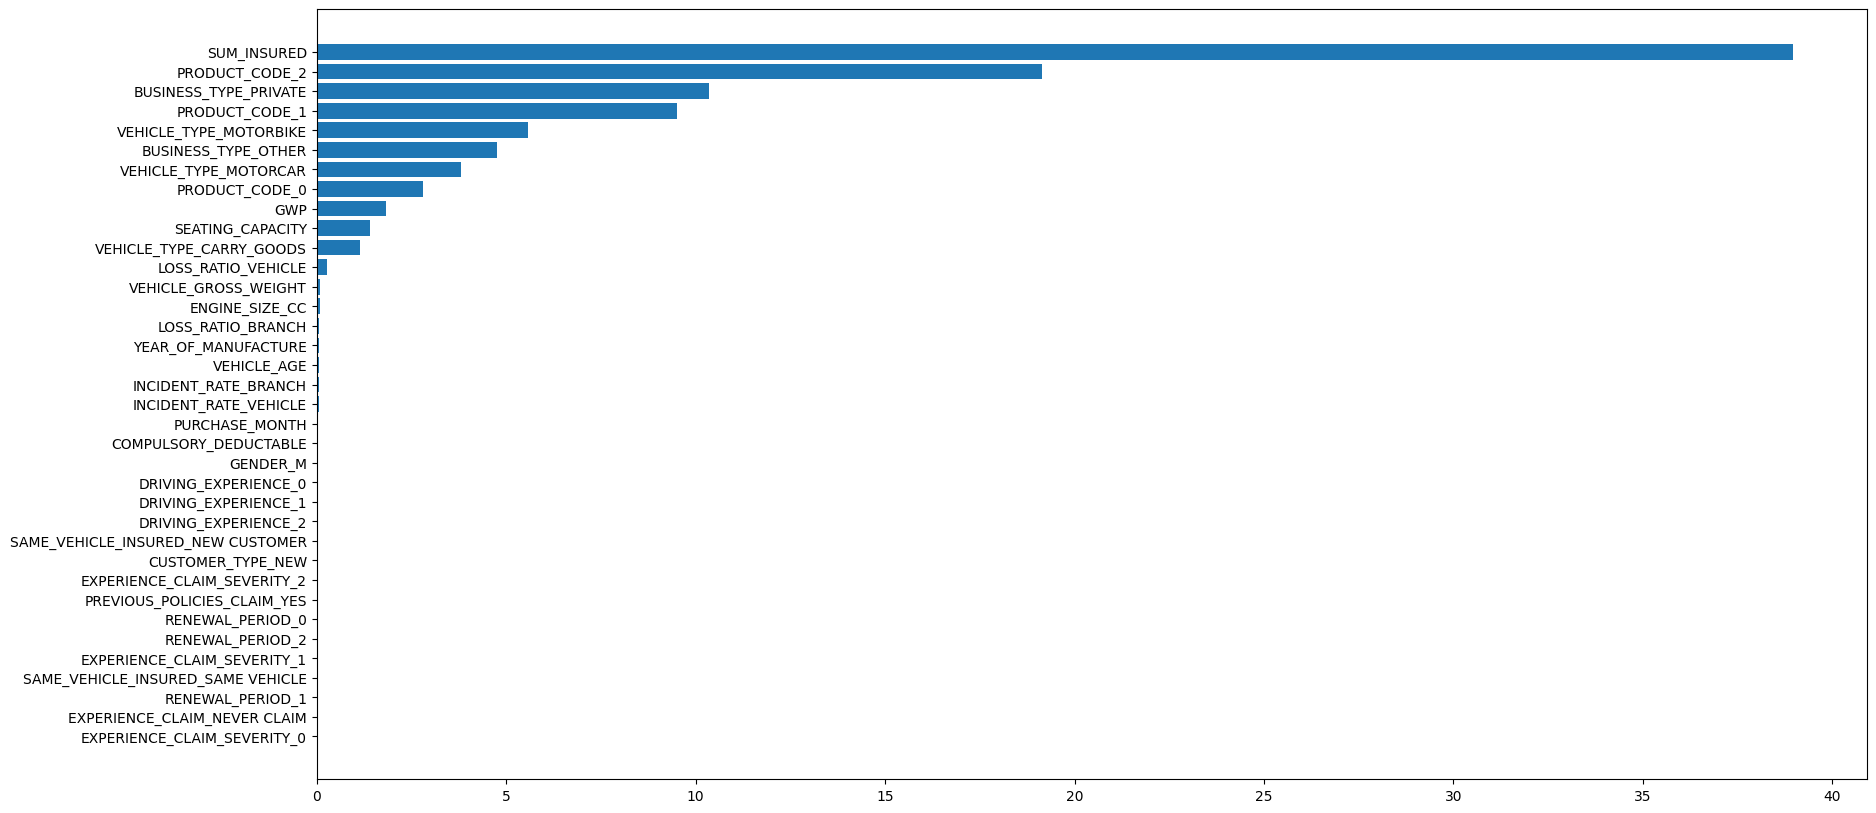

In [63]:
importances = model_cat.get_feature_importance()

# Sort feature importance
sorted_idx = importances.argsort()
plt.figure(figsize=(20, 10))
plt.barh(df_encode.iloc[:, 2:].columns[sorted_idx], importances[sorted_idx])
plt.show()

## Model Inference


In [64]:
# Predict Output
y_pred_proba_train = model_cat.predict_proba(X_train)[:, 1]
y_pred_train = model_cat.predict(X_train)

y_pred_proba_test = model_cat.predict_proba(X_test)[:, 1]
y_pred_test = model_cat.predict(X_test)

y_pred_proba_val = model_cat.predict_proba(X_val)[:, 1]
y_pred_val = model_cat.predict(X_val)

# Creating results DataFrame
df_result_train = pd.DataFrame(X_train_id)
df_result_train['pred'] = y_pred_train
df_result_train['proba'] = y_pred_proba_train
df_result_train['actual'] = y_train

df_result_test = pd.DataFrame(X_test_id)
df_result_test['pred'] = y_pred_test
df_result_test['proba'] = y_pred_proba_test
df_result_test['actual'] = y_test

df_result_val = pd.DataFrame(X_val_id)
df_result_val['pred'] = y_pred_val
df_result_val['proba'] = y_pred_proba_val
df_result_val['actual'] = y_val

# Combine results
temp = pd.concat([df_result_train, df_result_test], ignore_index=True)
df_result = pd.concat([temp, df_result_val], ignore_index=True)
df_result.columns = ['POLICY_IDENTIFIER', 'PRED', 'PROBA', 'ACTUAL']


## Summary Result

In [65]:
print('Train')
model_evaluation(model_cat, X_train, y_train)
print('Test')
model_evaluation(model_cat, X_test, y_test)
print('Val')
model_evaluation(model_cat, X_val, y_val)


Train
Confussin Matrix :
[[1092117       4]
 [ 197781   30098]]

Model Metrics
Accuracy   :0.8501628787878788
Precision  :0.9998671184638894
Recall     :0.13207886641594882
F1         :0.23333501304359625
ROC AUC    :0.5660376019090616
Test
Confussin Matrix :
[[136600      1]
 [ 24645   3754]]

Model Metrics
Accuracy   :0.8506303030303031
Precision  :0.9997336884154461
Recall     :0.13218775308989753
F1         :0.2335012751135162
ROC AUC    :0.5660902162496362
Val
Confussin Matrix :
[[136474      2]
 [ 24747   3777]]

Model Metrics
Accuracy   :0.8500060606060607
Precision  :0.9994707594601746
Recall     :0.13241480858224652
F1         :0.2338482493886017
ROC AUC    :0.5662000769954816


# Model Training using RandomForest

## Model Training

In [66]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=5)
model_rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5)

In [86]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 20,  # Reduce to limit model complexity and overfitting
    'learning_rate': 0.01,  # Keep learning rate low for stable training
    'n_estimators': 800,  # Slightly fewer boosting rounds
    'max_depth': 6,  # Limit depth to prevent overfitting
    'feature_fraction': 0.8,  # Keep this reasonable to avoid randomness
    'lambda_l1': 1.0,  # Increase L1 regularization to penalize complex models
    'lambda_l2': 1.0,  # Increase L2 regularization for more conservative predictions
    'min_data_in_leaf': 40,  # Larger leaves to prevent overfitting
    'class_weight': None,  # Remove class weighting to focus on precision
}

model_lgb = lgb.LGBMClassifier(**params)

model_lgb.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Number of positive: 227879, number of negative: 1092121
[LightGBM] [Info] Au

LGBMClassifier(feature_fraction=0.8, lambda_l1=1.0, lambda_l2=1.0,
               learning_rate=0.01, max_depth=6, min_data_in_leaf=40,
               n_estimators=800, num_leaves=20, objective='binary')

In [83]:
# Define the parameter grid
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10],
    'feature_fraction': [0.7, 0.8, 0.9]
}

model_lgb = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid,
    n_iter=20,  # Limits the search to 50 random combinations
    scoring='precision',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the grid search
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 227879, number of negative: 1092121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1531
[LightGBM] [Info] Number of data points in the train set: 1320000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172636 -> initscore=-1.567062
[LightGBM] [Info] Start training from score -1.567062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(objective='binary'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [15, 31, 63]},
                   random_state=42, scoring='precision', verbose=1)

## Model Evaluation

In [81]:
def model_evaluation(classfier,X,y):
    y_proba = classfier.predict_proba(X)[:, 1]
    y_pred = np.where(y_proba<0.55,0,1)

    cm = confusion_matrix(y,y_pred)
    print('Confussin Matrix :')
    print(cm)
    print('\nModel Metrics')
    print('Accuracy   :{}'.format(accuracy_score(y,y_pred)))
    print('Precision  :{}'.format(precision_score(y,y_pred)))
    print('Recall     :{}'.format(recall_score(y,y_pred)))
    print('F1         :{}'.format(f1_score(y,y_pred)))
    print('ROC AUC    :{}'.format(roc_auc_score(y,y_pred)))

In [75]:
print('Train')
model_evaluation(model_rf,X_train,y_train)
print('Test')
model_evaluation(model_rf,X_test,y_test)
print('Val')
model_evaluation(model_rf,X_val,y_val)

Train
Confussin Matrix :
[[1087322    4799]
 [  25825  202054]]

Model Metrics
Accuracy   :0.9768
Precision  :0.97679994972275
Recall     :0.8866723129380065
F1         :0.9295566003882852
ROC AUC    :0.9411390555983121
Test
Confussin Matrix :
[[127888   8713]
 [ 21450   6949]]

Model Metrics
Accuracy   :0.8171939393939394
Precision  :0.44368535308389734
Recall     :0.24469171449698934
F1         :0.3154263407548626
ROC AUC    :0.5904537041895859
Val
Confussin Matrix :
[[127832   8644]
 [ 21419   7105]]

Model Metrics
Accuracy   :0.8178
Precision  :0.45113975490507335
Recall     :0.24908848688823446
F1         :0.32096311521694937
ROC AUC    :0.5928756716805837


In [87]:
print('Train')
model_evaluation(model_lgb,X_train,y_train)
print('Test')
model_evaluation(model_lgb,X_test,y_test)
print('Val')
model_evaluation(model_lgb,X_val,y_val)

Train
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
Confussin Matrix :
[[1092117       4]
 [ 198203   29676]]

Model Metrics
Accuracy   :0.8498431818181819
Precision  :0.9998652291105121
Recall     :0.130227006437627
F1         :0.23044040394628026
ROC AUC    :0.5651116719199006
Test
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will 

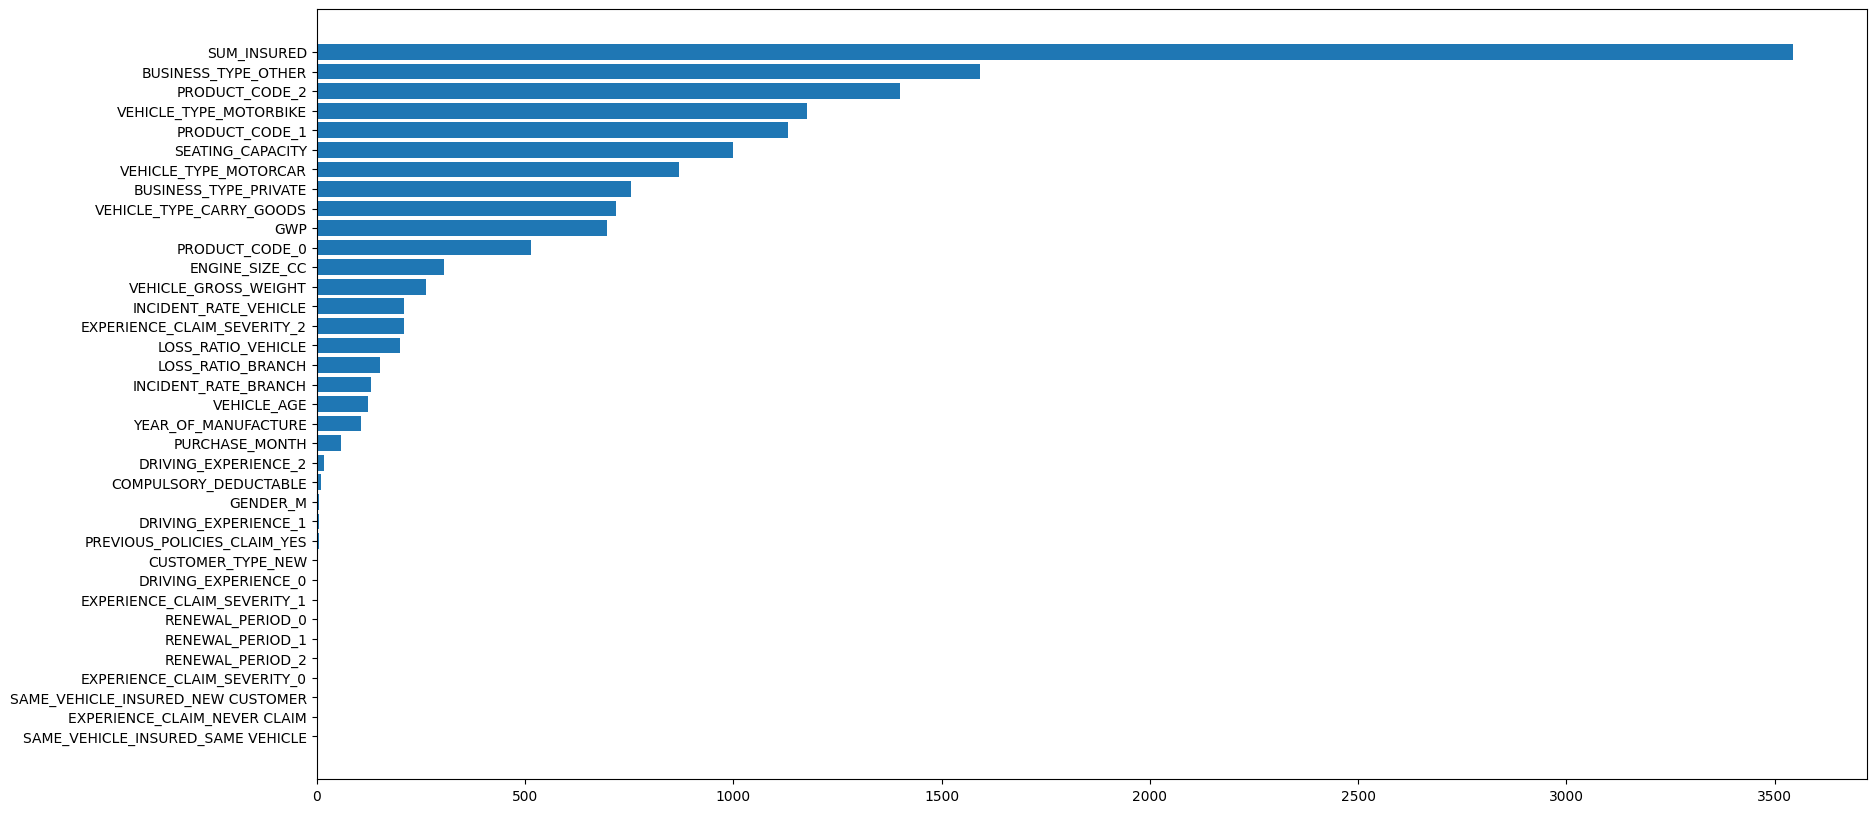

In [88]:
sorted_idx = model_lgb.feature_importances_.argsort()
plt.figure(figsize=(20,10))
plt.barh(df_encode.iloc[:,2:].columns[sorted_idx], model_lgb.feature_importances_[sorted_idx])
plt.show()

## Model Inference

In [89]:
# Predict Output
y_pred_proba_train = model_lgb.predict_proba(X_train)[:,1]
y_pred_train = model_lgb.predict(X_train)

y_pred_proba_test = model_lgb.predict_proba(X_test)[:,1]
y_pred_test = model_lgb.predict(X_test)

y_pred_proba_val = model_lgb.predict_proba(X_val)[:,1]
y_pred_val = model_lgb.predict(X_val)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current

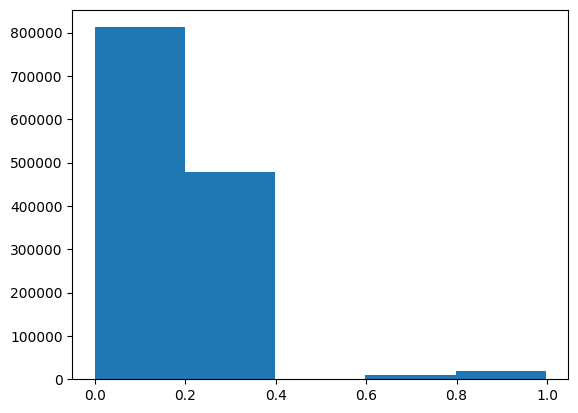

In [90]:
plt.hist(y_pred_proba_train,bins=5)
plt.show()

In [91]:
# Inferencing Result
df_result_train = pd.DataFrame(X_train_id)
df_result_train['pred'] = y_pred_train
df_result_train['proba'] = y_pred_proba_train
df_result_train['actual'] = y_train

df_result_test = pd.DataFrame(X_test_id)
df_result_test['pred'] = y_pred_test
df_result_test['proba'] = y_pred_proba_test
df_result_test['actual'] = y_test

df_result_val = pd.DataFrame(X_val_id)
df_result_val['pred'] = y_pred_val
df_result_val['proba'] = y_pred_proba_val
df_result_val['actual'] = y_val

In [92]:
temp = pd.concat([df_result_train,df_result_test],ignore_index=True)
df_result = pd.concat([temp,df_result_val],ignore_index=True)
df_result.columns = ['POLICY_IDENTIFIER','PRED','PROBA','ACTUAL']

In [93]:
df_result.head()

,POLICY_IDENTIFIER,PRED,PROBA,ACTUAL
0,POLICY_431409,0,0.09,0
1,POLICY_854125,0,0.30,1
2,POLICY_161170,0,0.01,0
3,POLICY_3279546,0,0.00,0
4,POLICY_2979118,0,0.22,1


In [94]:
datamart_pred = pd.merge(datamart,df_result,how='inner',on='POLICY_IDENTIFIER')

def premium_loading(prob):
  if prob < 0.5:
    return 0
  elif prob < 0.75:
    return 25
  elif prob <= 1:
    return 50

datamart_pred['GWP_ADJUSTED'] = datamart_pred['GWP']/(1 - datamart_pred['PROBA'].apply(premium_loading)/100 )

## Summary

The model return a good performance, with precision 99%. it means, from all the policy submission, all the customer with high probability of claim, will claim. The model is evaluated by using precison because, we want to avoid giving a high premium rates to wrong customer.

Model is check using 3 set of the data (Train, Test, Val) all return similar performance, hence we can conclude that the model is fit.

In [95]:
print('Train')
model_evaluation(model_lgb,X_train,y_train)
print('Test')
model_evaluation(model_lgb,X_test,y_test)
print('Val')
model_evaluation(model_lgb,X_val,y_val)

Train
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
Confussin Matrix :
[[1092117       4]
 [ 198203   29676]]

Model Metrics
Accuracy   :0.8498431818181819
Precision  :0.9998652291105121
Recall     :0.130227006437627
F1         :0.23044040394628026
ROC AUC    :0.5651116719199006
Test
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will 

Using predicted probability of policy submission, customer will get a premium loading if the probability of claim is meet a threshold.

Here is the thershold
1. No Loading for probability of claim < 50%
2. Loading 25% if probability of claim 50% < x < 75%
3. Loading 50% if probability of claim 75% < x < 100%

It means only customer with high probability of claim, will get a loading and rest of the customer with low probability of claim will pay the same amount.

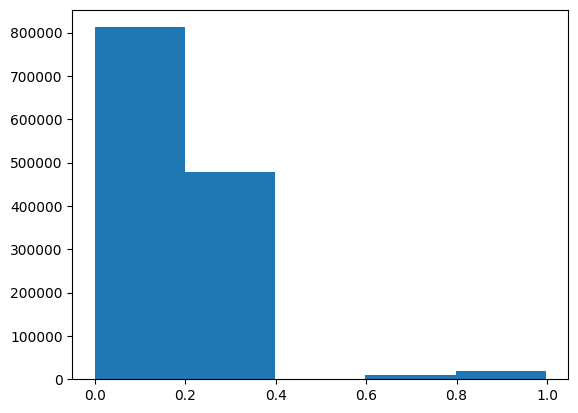

In [96]:
plt.hist(y_pred_proba_train,bins=5)
plt.show()

Using this approach, we are manage to lower down the Loss ratio by 3%. Loss ratio will also decreased by 18%, if the customer decide to withdraw their policy application after the GWP adjusted.

In [97]:
claim_ratio = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP.sum()
claim_ratio_adjusted = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP_ADJUSTED.sum()

print('Customer Apply')
print('GWP Original Loss Ratio : {}%'.format(claim_ratio * 100))
print('GWP Adjusted Loss Ratio : {}%'.format(claim_ratio_adjusted * 100))

claim_ratio = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP.sum()
claim_ratio_adjusted = datamart_pred[datamart_pred['PRED']==0].CLAIM_AMOUNT.sum()/datamart_pred[datamart_pred['PRED']==0].GWP_ADJUSTED.sum()

print('Customer Withdraw')
print('GWP Original Loss Ratio : {}%'.format(claim_ratio * 100))
print('GWP Adjusted Loss Ratio : {}%'.format(claim_ratio_adjusted * 100))

Customer Apply
GWP Original Loss Ratio : 17.1975281216669%
GWP Adjusted Loss Ratio : 16.892126881809183%
Customer Withdraw
GWP Original Loss Ratio : 17.1975281216669%
GWP Adjusted Loss Ratio : 15.321830828450414%


# Model Training Using XGBoost

## Model Training

In [98]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Base Model
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',  # Optimizing for F1 score
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [99]:
# Fit the grid search
random_search.fit(X_train, y_train)
model_xgb_best = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


## Model Evaluation


In [100]:
def model_evaluation(classifier, X, y):
    y_proba = classifier.predict_proba(X)[:, 1]
    y_pred = np.where(y_proba < 0.5, 0, 1)

    cm = confusion_matrix(y, y_pred)
    print('Confusion Matrix:')
    print(cm)
    print('\nModel Metrics')
    print(f'Accuracy   : {accuracy_score(y, y_pred)}')
    print(f'Precision  : {precision_score(y, y_pred)}')
    print(f'Recall     : {recall_score(y, y_pred)}')
    print(f'F1         : {f1_score(y, y_pred)}')
    print(f'ROC AUC    : {roc_auc_score(y, y_pred)}')

In [101]:
print('Train')
model_evaluation(model_xgb_best, X_train, y_train)
print('Test')
model_evaluation(model_xgb_best, X_test, y_test)
print('Validation')
model_evaluation(model_xgb_best, X_val, y_val)

Train
Confusion Matrix:
[[1091967     154]
 [ 170477   57402]]

Model Metrics
Accuracy   : 0.8707340909090909
Precision  : 0.997324344985753
Recall     : 0.25189683998964363
F1         : 0.4022071574964528
ROC AUC    : 0.625877914986677
Test
Confusion Matrix:
[[136031    570]
 [ 24412   3987]]

Model Metrics
Accuracy   : 0.8485939393939393
Precision  : 0.8749177090190915
Recall     : 0.1403922673333568
F1         : 0.24195897560383542
ROC AUC    : 0.5681097653384817
Validation
Confusion Matrix:
[[135927    549]
 [ 24486   4038]]

Model Metrics
Accuracy   : 0.8482727272727273
Precision  : 0.8803139306736429
Recall     : 0.1415649978965082
F1         : 0.24390685874784815
ROC AUC    : 0.5687711562946007


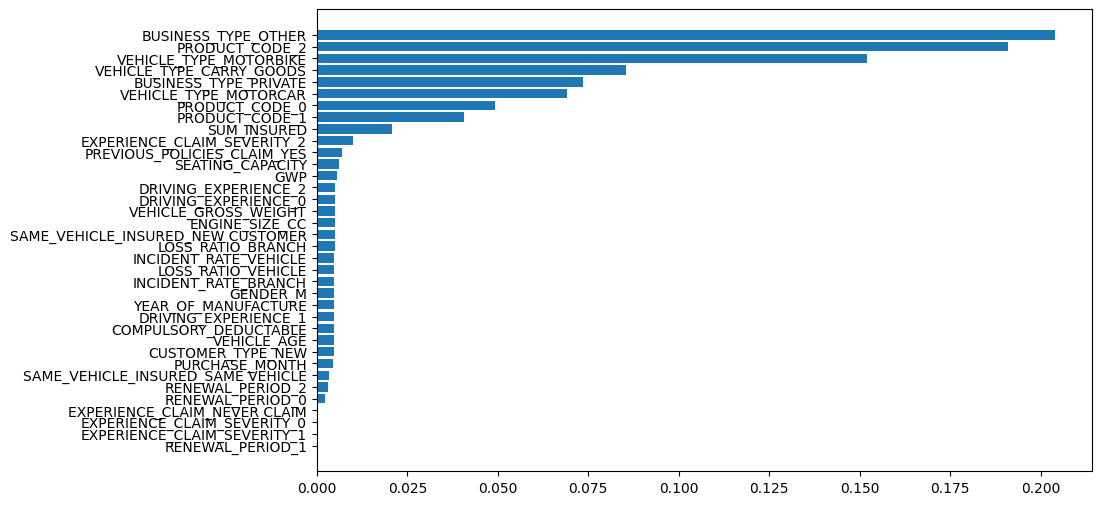

In [102]:
sorted_idx = model_xgb_best.feature_importances_.argsort()
plt.figure(figsize=(10, 6))
plt.barh(df_encode.iloc[:, 2:].columns[sorted_idx], model_xgb_best.feature_importances_[sorted_idx])
plt.show()

## Model Inference

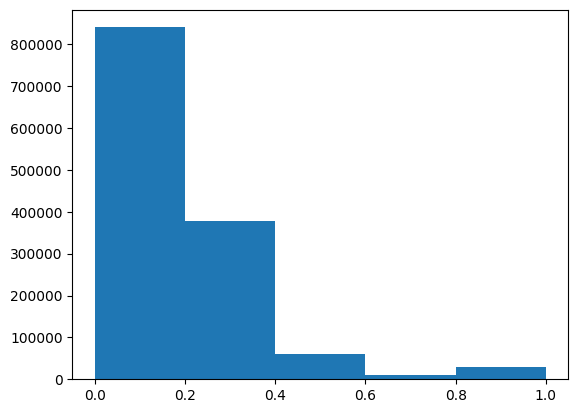

In [103]:
# Predictions and Probabilities
y_pred_proba_train = model_xgb_best.predict_proba(X_train)[:, 1]
y_pred_train = model_xgb_best.predict(X_train)

y_pred_proba_test = model_xgb_best.predict_proba(X_test)[:, 1]
y_pred_test = model_xgb_best.predict(X_test)

y_pred_proba_val = model_xgb_best.predict_proba(X_val)[:, 1]
y_pred_val = model_xgb_best.predict(X_val)

plt.hist(y_pred_proba_train, bins=5)
plt.show()


In [104]:
# Results DataFrame
df_result_train = pd.DataFrame(X_train_id)
df_result_train['pred'] = y_pred_train
df_result_train['proba'] = y_pred_proba_train
df_result_train['actual'] = y_train

In [105]:
df_result_test = pd.DataFrame(X_test_id)
df_result_test['pred'] = y_pred_test
df_result_test['proba'] = y_pred_proba_test
df_result_test['actual'] = y_test

In [106]:
df_result_val = pd.DataFrame(X_val_id)
df_result_val['pred'] = y_pred_val
df_result_val['proba'] = y_pred_proba_val
df_result_val['actual'] = y_val

In [107]:
temp = pd.concat([df_result_train, df_result_test], ignore_index=True)
df_result = pd.concat([temp, df_result_val], ignore_index=True)
df_result.columns = ['POLICY_IDENTIFIER', 'PRED', 'PROBA', 'ACTUAL']

## Model Summary

In [110]:
print('Train')
model_evaluation(model_xgb_best, X_train, y_train)
print('Test')
model_evaluation(model_xgb_best, X_test, y_test)
print('Validation')
model_evaluation(model_xgb_best, X_val, y_val)


Train
Confusion Matrix:
[[1091967     154]
 [ 170477   57402]]

Model Metrics
Accuracy   : 0.8707340909090909
Precision  : 0.997324344985753
Recall     : 0.25189683998964363
F1         : 0.4022071574964528
ROC AUC    : 0.625877914986677
Test
Confusion Matrix:
[[136031    570]
 [ 24412   3987]]

Model Metrics
Accuracy   : 0.8485939393939393
Precision  : 0.8749177090190915
Recall     : 0.1403922673333568
F1         : 0.24195897560383542
ROC AUC    : 0.5681097653384817
Validation
Confusion Matrix:
[[135927    549]
 [ 24486   4038]]

Model Metrics
Accuracy   : 0.8482727272727273
Precision  : 0.8803139306736429
Recall     : 0.1415649978965082
F1         : 0.24390685874784815
ROC AUC    : 0.5687711562946007


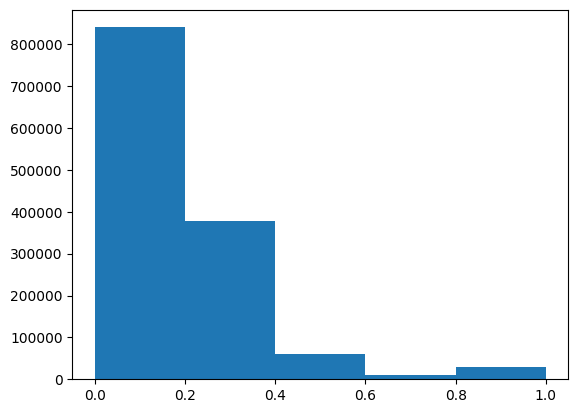

In [111]:
plt.hist(y_pred_proba_train, bins=5)
plt.show()


In [112]:

# Premium Loading Calculation
def premium_loading(prob):
    if prob < 0.5:
        return 0
    elif prob < 0.75:
        return 25
    elif prob <= 1:
        return 50



In [113]:
datamart_pred = pd.merge(datamart, df_result, how='inner', on='POLICY_IDENTIFIER')
datamart_pred['GWP_ADJUSTED'] = datamart_pred['GWP'] / (1 - datamart_pred['PROBA'].apply(premium_loading) / 100)

claim_ratio = datamart_pred.CLAIM_AMOUNT.sum() / datamart_pred.GWP.sum()
claim_ratio_adjusted = datamart_pred.CLAIM_AMOUNT.sum() / datamart_pred.GWP_ADJUSTED.sum()



In [114]:
print('Customer Apply')
print(f'GWP Original Loss Ratio : {claim_ratio * 100}%')
print(f'GWP Adjusted Loss Ratio : {claim_ratio_adjusted * 100}%')



Customer Apply
GWP Original Loss Ratio : 17.1975281216669%
GWP Adjusted Loss Ratio : 16.719627003097735%


In [115]:
# Withdrawals Only
claim_ratio_adjusted_withdraw = datamart_pred[datamart_pred['PRED'] == 0].CLAIM_AMOUNT.sum() / \
                                datamart_pred[datamart_pred['PRED'] == 0].GWP_ADJUSTED.sum()



In [116]:
print('Customer Withdraw')
print(f'GWP Original Loss Ratio : {claim_ratio * 100}%')
print(f'GWP Adjusted Loss Ratio : {claim_ratio_adjusted_withdraw * 100}%')

Customer Withdraw
GWP Original Loss Ratio : 17.1975281216669%
GWP Adjusted Loss Ratio : 13.847957011794087%
